In [1]:
from seirsplus.models import *
# from models import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from multiprocessing import Pool, freeze_support
import pickle
import datetime
%matplotlib inline


In [2]:
observations = pd.read_csv("data/Ahmedabad_new.csv") 

observations['Dates'] = observations['Date'].apply(pd.to_datetime, format = "%Y-%m-%d")


observations = observations.set_index('Dates')
observations = observations.drop('Date', axis = 1)
observations = observations.rename(columns={'confirmed':'patient'})
observations = observations*100/(860000)

In [3]:
numNodes = 10000
baseGraph1 =    networkx.barabasi_albert_graph(n=numNodes, m=6)
G_normal1     = baseGraph1

baseGraph2    = nx.erdos_renyi_graph(n=numNodes, p = np.log(numNodes)/numNodes , seed=42, directed=False)
G_normal2     = baseGraph2
G_Quarantine = nx.erdos_renyi_graph(n=numNodes, p = 0.45/numNodes , seed=42, directed=False)
G_Distancing = nx.erdos_renyi_graph(n=numNodes, p = 0.8/numNodes , seed=42, directed=False)
G_relaxed = nx.erdos_renyi_graph(n=numNodes, p = 2.5/numNodes , seed=42, directed=False)
G_Quarantine_strict = nx.erdos_renyi_graph(n=numNodes, p = 0.35/numNodes , seed=42, directed=False)

In [41]:
# Below section for creating graphs and monte carlo simul

def get_three_tuple(df):
    arr = []
    for row in df.iterrows():
        v1 = np.percentile(row[1], 25)
        v2 = np.percentile(row[1], 50)
        v3 = np.percentile(row[1], 75)
        arr.append(np.array([v1,v2,v3]))
    return np.array(arr)

def single_run(model_init, model_run, i):
    model = SEIRSNetworkModel(**model_init)
    model.run(**model_run)
    time=pd.to_datetime(pd.Series(model.tseries),unit='d',origin='2020-04-27')   
    
    df_tempI=pd.DataFrame({'t':time, i:model.numI})
    df_tempI.set_index('t',inplace=True)
    df_tempI['t']=df_tempI.index.date
    df_tempI.reset_index(drop=True,inplace=True)
    df_tempI.set_index('t',inplace=True)
    df_tempI.reset_index(inplace=True)
    df_tempI = pd.pivot_table(df_tempI, index='t', aggfunc='mean')

    df_tempDI=pd.DataFrame({'t':time, i:model.numD_I})
    df_tempDI.set_index('t',inplace=True)
    df_tempDI['t']=df_tempDI.index.date
    df_tempDI.reset_index(drop=True,inplace=True)
    df_tempDI.set_index('t',inplace=True)
    df_tempDI.reset_index(inplace=True)
    df_tempDI= pd.pivot_table(df_tempDI, index='t', aggfunc='mean')

    df_tempR=pd.DataFrame({'t':time, i:model.numR})
    df_tempR.set_index('t',inplace=True)
    df_tempR['t']=df_tempR.index.date
    df_tempR.reset_index(drop=True,inplace=True)
    df_tempR.set_index('t',inplace=True)
    df_tempR.reset_index(inplace=True)
    df_tempR= pd.pivot_table(df_tempR, index='t', aggfunc='mean')

    df_tempF=pd.DataFrame({'t':time, i:model.numF})
    df_tempF.set_index('t',inplace=True)
    df_tempF['t']=df_tempF.index.date
    df_tempF.reset_index(drop=True,inplace=True)
    df_tempF.set_index('t',inplace=True)
    df_tempF.reset_index(inplace=True)
    df_tempF= pd.pivot_table(df_tempF, index='t', aggfunc='mean')

    return df_tempI, df_tempDI, df_tempR, df_tempF

def monte(N, initI,theta_E, theta_I ,mf, checkpoints, G=G_Distancing, sim=2):
    beta = 0.185
    sigma = 1/5.2
    gamma = 1/15
    mu_I = 0.004
    p = 0.6
    Q = None
    beta_D = 0.155
    sigma_D = 1/5.2
    mu_D = 0#0.0004
    theta_E = theta_E
    theta_I = 0.004
    phi_E = 0.4
    phi_I = 0.8
    initN = 10000
    initI = initI
    initE = initI*4
    initD_E = 0.0
    initD_I = int(observations.patient.values[0]/100)+1
    initR = 0
    initF = 0
    x_i = 0.001
    psi_E = 0.04
    psi_I = 1
    q = 0.3
    gamma_D = 0#gamma

    # Creating dataframe
    time_index=pd.date_range(start='2020-04-01', periods=90)
    df_I=pd.DataFrame(index=time_index)
    df_DI=pd.DataFrame(index=time_index)
    df_R = pd.DataFrame(index=time_index)
    df_F = pd.DataFrame(index=time_index)
    
    model_init = {'G' : G, 'Q' : G_Quarantine_strict, 'beta' : beta, 'sigma' : sigma,
                 'gamma' : gamma, 'mu_I' : mu_I, 'beta_D' : beta_D, 'sigma_D' : sigma_D,
                 'gamma_D' : gamma_D, 'mu_D' : mu_D, 'theta_E' : theta_E, 'theta_I' : theta_I,
                 'phi_E' : phi_E, 'phi_I' : phi_I, 'psi_E' : psi_E, 'psi_I' : psi_I, 'q' : 0.3,
                 'initI' : initI, 'initE' : initE, 'initD_E' : initD_E, 'initD_I' : initD_I}
    
    model_run = {'T':180, 'checkpoints':checkpoints, 'verbose':False}
    
    pool = Pool(processes = 32)
    
    results = []
    for i in range(1, sim+1):
        results.append(pool.apply_async(single_run, args=(model_init, model_run, i)))
    
    pool.close()
    pool.join()

    for res in results:
        df_l = res.get()
        df_I=df_I.merge(df_l[0], how='outer', right_index=True, left_index=True).ffill(axis=0).fillna(np.NaN)        

        df_DI=df_DI.merge(df_l[1], how='outer', right_index=True, left_index=True).ffill(axis=0).fillna(np.NaN)        

        df_R=df_R.merge(df_l[2], how='outer', right_index=True, left_index=True).ffill(axis=0).fillna(np.NaN)

        df_F=df_F.merge(df_l[3], how='outer', right_index=True, left_index=True).ffill(axis=0).fillna(np.NaN)
        
        df_I =df_I.interpolate(method='linear', limit_direction='forward', axis=0)
        df_DI =df_DI.interpolate(method='linear', limit_direction='forward', axis=0)
        df_R = df_R.interpolate(method='linear',limit_direction='forward',axis = 0)
        df_F = df_F.interpolate(method='linear',limit_direction='forward',axis = 0)

    df_I = df_I*100.0/N
    df_DI = df_DI*100.0/N
    df_R = df_R*100.0/N
    df_F = df_F*100.0/N
    
    return df_I, df_DI, df_R, df_F

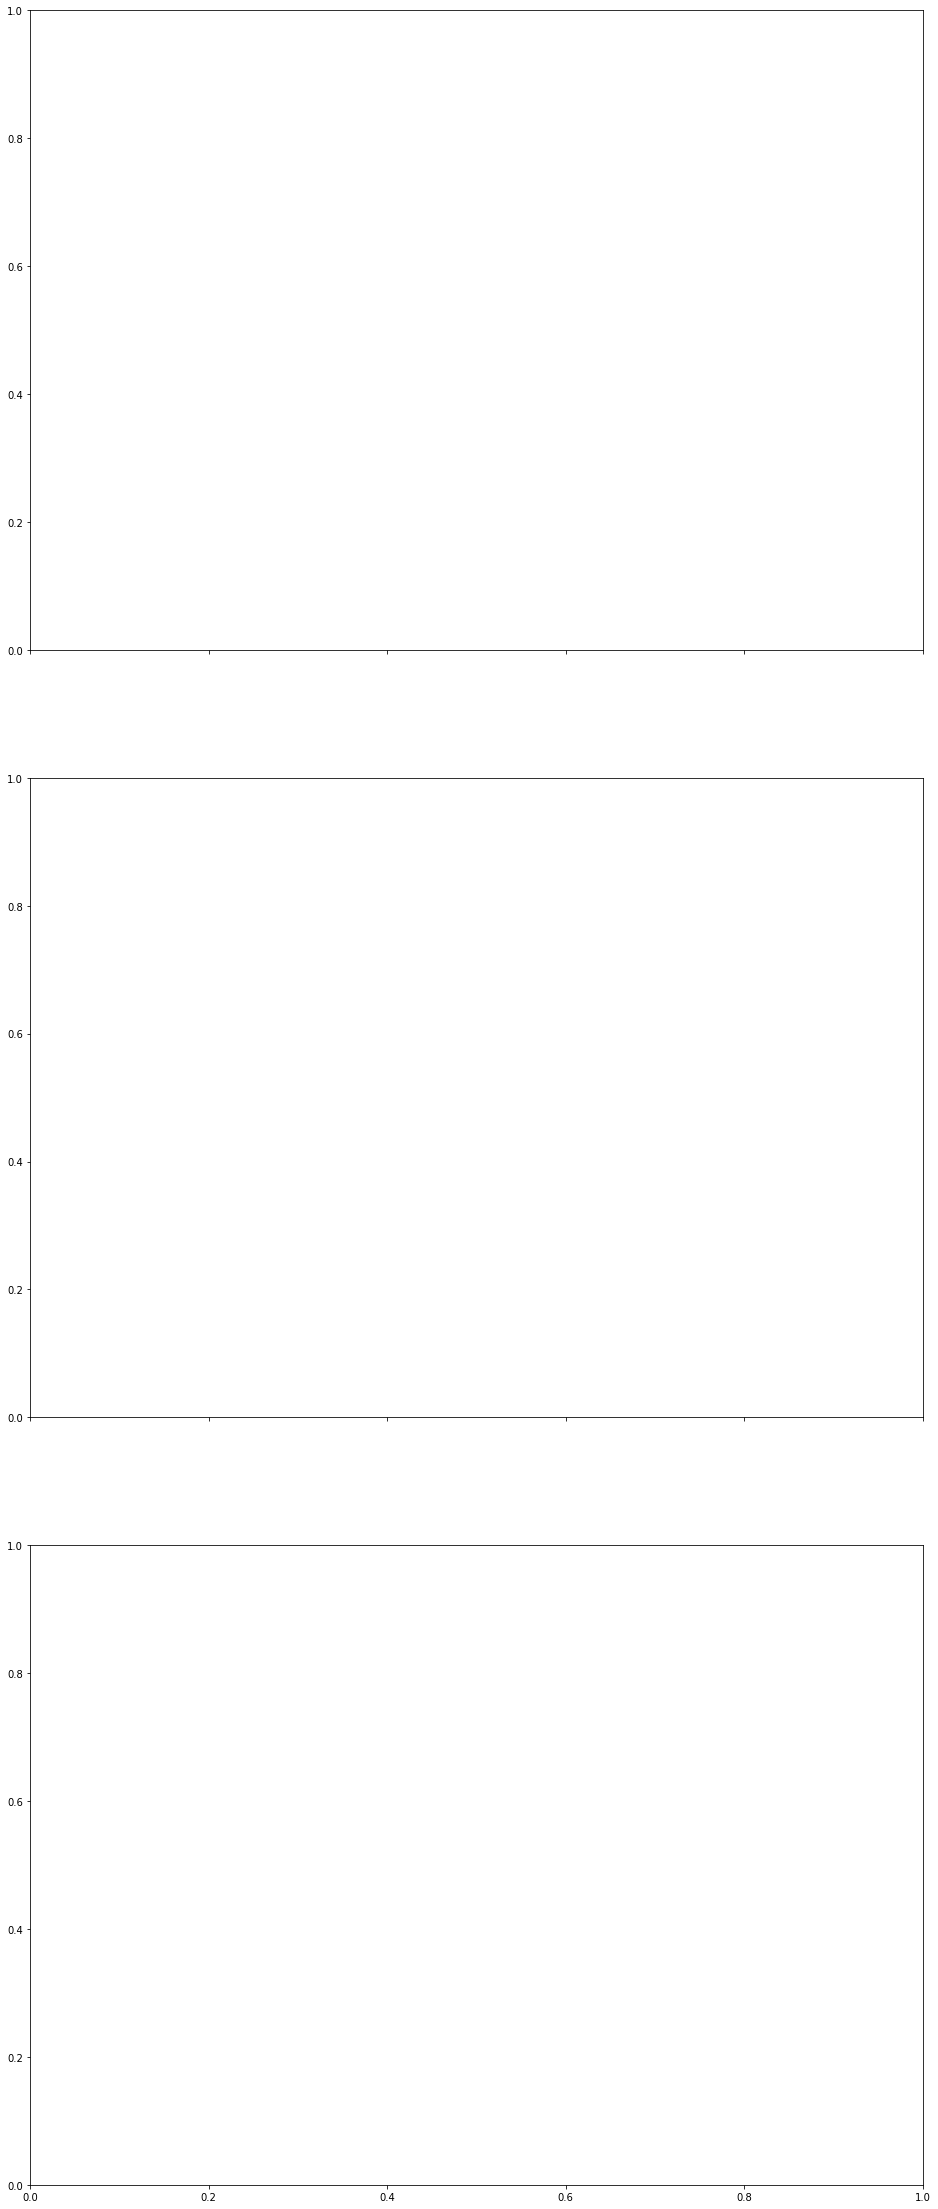

In [69]:
freeze_support()


plt.rcParams["figure.figsize"] = (16,40)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

In [70]:
# With current testing and social distancing throughout
final = []
initI = 100*(int(observations.patient.values[0]/100)+1)
theta_E = 0.000
theta_I = 0.01
mf = 1
checkpoints  =  {'t': [20,45,65,95],
                   'theta_E': [0.004*mf,0.004*mf,0.004*mf,0.005*mf],
                 'G': [G_Quarantine,G_Distancing,G_relaxed, G_normal2]
                      }

temp = monte(N=10000,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_Quarantine_strict, sim=1000)
with open('data/Ahm_strict.p', 'wb') as fp:
    pickle.dump(temp, fp)

In [71]:
dfa_I = temp[0]
cumuI = get_three_tuple(dfa_I)
ax1.plot(dfa_I.index, cumuI[:,1],linewidth = 3)

dfa_DI = temp[1]
cumuDI = get_three_tuple(dfa_DI.diff(axis=0))
ax1.plot(dfa_DI.index, cumuDI[:,1],linewidth = 3)

ax1.fill_between(
    dfa_I.index,
    cumuI[:,0],
    cumuI[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax1.fill_between(
    dfa_DI.index,
    cumuDI[:,0],
    cumuDI[:,2],
     color='orange', alpha=.3, label='IQR'
    )

ax1.plot(observations.index.values, observations.patient.values,linewidth = 3)
ax1.legend(['Infected','New Detected','Observed Detected','Infected IQR','Detected IQR'],fontsize =25,loc = 1)
#ax1.set_xlabel("Time", fontsize = 20)
#ax1.set_ylabel("% Population infected", fontsize = 20)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.axvline(x=datetime.datetime(2020, 6, 1),  linestyle='dashed',c='k')
#fig.set_size_inches(15, 9, forward=True)
#plt.suptitle("Ahmedabad: Red zone", fontsize=34,color = "red")
#ax.set_title("Continued Testing at current rate with strictness till 15 May",fontsize = 30)
#ax.text(df.index.values[86],0.05,s = "Total population = 7.5 Million", bbox=dict(facecolor='red', alpha=0.25))
#fig.savefig("Ahm_sim/Continued_testing_strictness_till_15_May.svg")

In [72]:
# With current testing and social distancing throughout
final = []
initI = 100*(int(observations.patient.values[0]/100)+1)
theta_E = 0.000
theta_I = 0.01
mf = 1
checkpoints  =  {'t': [30,45,65,75],
                   'theta_E': [0.004*mf,0.004*mf,0.004*mf, 0.005*mf],
                 'G': [G_Quarantine,G_Distancing,G_relaxed, G_normal2]
                      }

temp = monte(N=10000,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_Quarantine_strict, sim=1000)
with open('data/Ahm_distancing.p', 'wb') as fp:
    pickle.dump(temp, fp)

In [73]:
dfa_I = temp[0]
cumuI = get_three_tuple(dfa_I)
ax2.plot(dfa_I.index, cumuI[:,1],linewidth = 3)

dfa_DI = temp[1]
cumuDI = get_three_tuple(dfa_DI.diff(axis=0))
ax2.plot(dfa_DI.index, cumuDI[:,1],linewidth = 3)

ax2.fill_between(
    dfa_I.index,
    cumuI[:,0],
    cumuI[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax2.fill_between(
    dfa_DI.index,
    cumuDI[:,0],
    cumuDI[:,2],
     color='orange', alpha=.3, label='IQR'
    )

ax2.plot(observations.index.values, observations.patient.values,linewidth = 3)
ax2.legend(['Infected','Detected','Observed Detected','Infected IQR','Detected IQR'],fontsize =25,loc = 1)
#ax.set_xlabel("Time", fontsize = 20)
#ax.set_ylabel("% Population infected", fontsize = 20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.axvline(x=datetime.datetime(2020, 6, 1), linestyle='dashed',c='k')
#fig.set_size_inches(15, 9, forward=True)
#plt.suptitle("Ahmedabad: Red zone", fontsize=34,color = "red")
#ax.set_title("Continued Testing at current rate with Strict Distancing after May 15",fontsize = 30)
#ax.text(df.index.values[86],0.05,s = "Total population = 7.5 Million", bbox=dict(facecolor='red', alpha=0.25))
#fig.savefig("Ahm_sim/strict_distancing_curr_testing.svg")

In [74]:
# 3. With current testing and and no social distancing throughout
final = []
initI = 100*(int(observations.patient.values[0]/100)+1)
theta_E = 0.000
theta_I = 0.01
mf = 1
checkpoints  =  {'t': [30,65,95],
                   'theta_E': [0.004*mf,0.004*mf,0.005*mf],
                 'G': [G_Quarantine,G_Distancing,G_normal2]
                      }
temp = monte(N=10000,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_Quarantine_strict, sim=1000)
with open('data/Ahm_no_distancing.p', 'wb') as fp:
    pickle.dump(temp, fp)

In [75]:
dfa_I = temp[0]
cumuI = get_three_tuple(dfa_I)
ax3.plot(dfa_I.index, cumuI[:,1],linewidth = 3)

dfa_DI = temp[1]
cumuDI = get_three_tuple(dfa_DI.diff(axis=0))
ax3.plot(dfa_DI.index, cumuDI[:,1],linewidth = 3)

ax3.fill_between(
    dfa_I.index,
    cumuI[:,0],
    cumuI[:,2],
     color='b', alpha=.1, label='IQR'
    )

ax3.fill_between(
    dfa_DI.index,
    cumuDI[:,0],
    cumuDI[:,2],
     color='orange', alpha=.3, label='IQR'
    )

ax3.plot(observations.index.values, observations.patient.values,linewidth = 3)
ax3.legend(['Infected','Detected','Observed Detected','Infected IQR','Detected IQR'],fontsize =25,loc =1)
#ax3.set_xlabel("Time", fontsize = 20)
#ax.set_ylabel("% Population infected", fontsize = 20)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
ax3.axvline(x=datetime.datetime(2020, 6, 1), linestyle='dashed',c='k')
#fig.set_size_inches(15, 9, forward=True)
#plt.suptitle("Ahmedabad: Red zone", fontsize=34,color = "red")
#ax.set_title("Continued Testing at current rate with eased restrictions after May 15",fontsize = 30)
#ax.text(df.index.values[86],0.05,s = "Total population = 7.5 Million", bbox=dict(facecolor='red', alpha=0.25))
#fig.savefig("Ahm_sim/no_distancing_curr_testing.svg")

In [76]:
fig.savefig('figures/f4.svg')

In [77]:
fig.savefig('figures/f4.pdf')

10
t = 0.01
	 S   = 9975.0
	 E   = 19.0
	 I   = 6.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 0.0
	 F   = 0.0
[Checkpoint: Updating parameters]
t = 10.30
	 S   = 9954.0
	 E   = 10.0
	 I   = 22.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 10.0
	 F   = 2.0
[Checkpoint: Updating parameters]
t = 20.09
	 S   = 9923.0
	 E   = 17.0
	 I   = 19.0
	 D_E = 0.0
	 D_I = 3.0
	 R   = 35.0
	 F   = 3.0
t = 30.03
	 S   = 9900.0
	 E   = 14.0
	 I   = 26.0
	 D_E = 0.0
	 D_I = 3.0
	 R   = 54.0
	 F   = 3.0
t = 40.02
	 S   = 9870.0
	 E   = 16.0
	 I   = 34.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 73.0
	 F   = 5.0
[Checkpoint: Updating parameters]
t = 50.01
	 S   = 9844.0
	 E   = 10.0
	 I   = 40.0
	 D_E = 0.0
	 D_I = 6.0
	 R   = 95.0
	 F   = 5.0
t = 60.39
	 S   = 9834.0
	 E   = 5.0
	 I   = 30.0
	 D_E = 0.0
	 D_I = 4.0
	 R   = 119.0
	 F   = 8.0
t = 80.45
	 S   = 9828.0
	 E   = 2.0
	 I   = 11.0
	 D_E = 0.0
	 D_I = 1.0
	 R   = 149.0
	 F   = 9.0
t = 90.55
	 S   = 9825.0
	 E   = 0.0
	 I   = 6.0
	 D_E = 0.0
	 D_I = 1.0
	 R   = 159.0
	 F   = 9.0

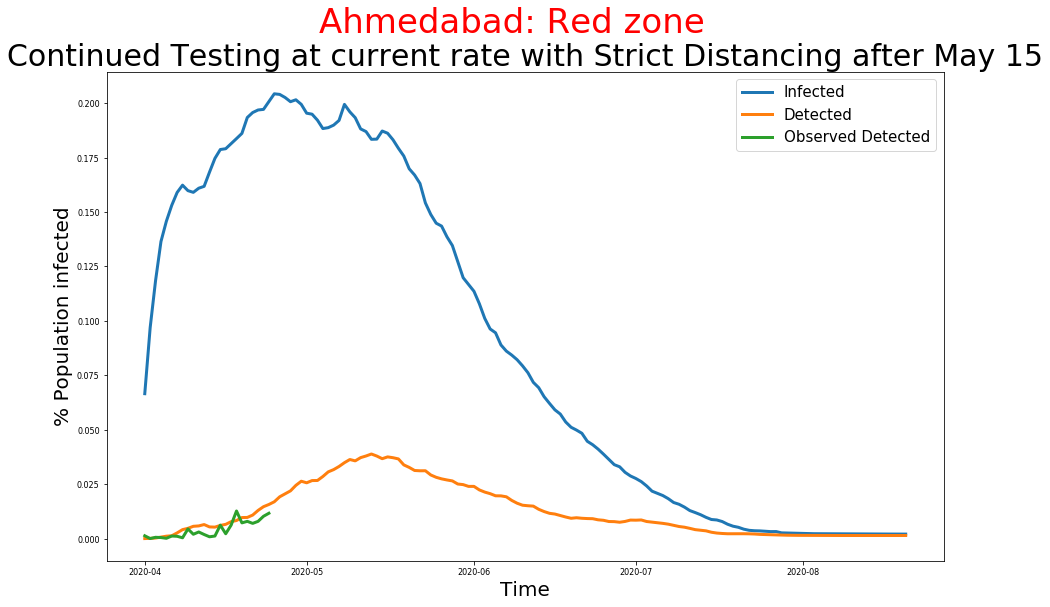

In [6]:
# 2. With current testing and social distancing throughout
final = []
initI = 5
theta_E = 0.000
theta_I = 0.01
mf = 1
checkpoints  =  {'t': [10,15,45],
                   'theta_E': [0.0002*mf,0.004*mf,0.004*mf],
                 'G': [G_relaxed,G_relaxed,G_Distancing]
                      }
Ns = range(10,12,2)
for N in Ns:
    print(N)
    temp = monte(initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_Distancing)
    final.append(temp)
fig,ax = plt.subplots()
for i in final:
    df = i['df_I']
    ax.plot(df,linewidth = 3)
    ax.plot(i['df_DI'],linewidth = 3)
    ax.plot(observations.index.values, observations.patient.values,linewidth = 3)
    ax.legend(['Infected','Detected','Observed Detected','I =.11','I =.13'],fontsize =15,loc = 1)
    ax.set_xlabel("Time", fontsize = 20)
    ax.set_ylabel("% Population infected", fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    fig.set_size_inches(15, 9, forward=True)
    plt.suptitle("Ahmedabad: Red zone", fontsize=34,color = "red")
    ax.set_title("Continued Testing at current rate with Strict Distancing after May 15",fontsize = 30)
    #ax.text(df.index.values[86],0.05,s = "Total population = 7.5 Million", bbox=dict(facecolor='red', alpha=0.25))
    fig.savefig("2.strict_distancing_curr_testing.png")

10
t = 0.25
	 S   = 9975.0
	 E   = 19.0
	 I   = 6.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 0.0
	 F   = 0.0
[Checkpoint: Updating parameters]
t = 10.02
	 S   = 9965.0
	 E   = 12.0
	 I   = 18.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 5.0
	 F   = 0.0
[Checkpoint: Updating parameters]
t = 20.36
	 S   = 9947.0
	 E   = 10.0
	 I   = 22.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 21.0
	 F   = 0.0
t = 30.04
	 S   = 9931.0
	 E   = 8.0
	 I   = 22.0
	 D_E = 0.0
	 D_I = 3.0
	 R   = 35.0
	 F   = 1.0
t = 40.23
	 S   = 9906.0
	 E   = 15.0
	 I   = 26.0
	 D_E = 0.0
	 D_I = 1.0
	 R   = 49.0
	 F   = 3.0
[Checkpoint: Updating parameters]
t = 50.23
	 S   = 9878.0
	 E   = 16.0
	 I   = 31.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 69.0
	 F   = 4.0
t = 60.05
	 S   = 9834.0
	 E   = 24.0
	 I   = 46.0
	 D_E = 1.0
	 D_I = 6.0
	 R   = 84.0
	 F   = 5.0
t = 70.01
	 S   = 9772.0
	 E   = 26.0
	 I   = 57.0
	 D_E = 0.0
	 D_I = 11.0
	 R   = 128.0
	 F   = 6.0
t = 80.06
	 S   = 9687.0
	 E   = 43.0
	 I   = 71.0
	 D_E = 1.0
	 D_I = 9.0
	 R   = 180.0
	 F   = 9

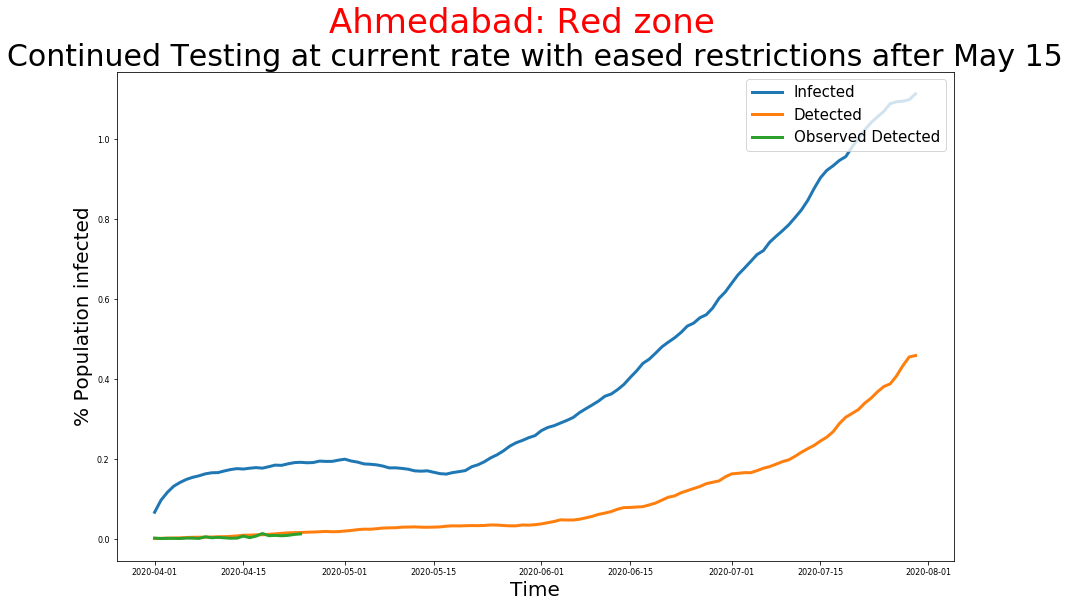

In [7]:
# 3. With current testing and and no social distancing throughout
final = []
initI = 5
theta_E = 0.000
theta_I = 0.01
mf = 1
checkpoints  =  {'t': [10,15,45],
                   'theta_E': [0.0002*mf,0.004*mf,0.004*mf],
                 'G': [G_relaxed,G_relaxed,G_normal2]
                      }
for N in Ns:
    print(N)
    temp = monte(initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_Distancing)
    final.append(temp)
fig,ax = plt.subplots()
for i in final:
    df = i['df_I']
    ax.plot(df,linewidth = 3)
    ax.plot(i['df_DI'],linewidth = 3)
    ax.plot(observations.index.values, observations.patient.values,linewidth = 3)
    ax.legend(['Infected','Detected','Observed Detected','I =.11','I =.13'],fontsize =15,loc = 1)
    ax.set_xlabel("Time", fontsize = 20)
    ax.set_ylabel("% Population infected", fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    fig.set_size_inches(15, 9, forward=True)
    plt.suptitle("Ahmedabad: Red zone", fontsize=34,color = "red")
    ax.set_title("Continued Testing at current rate with eased restrictions after May 15",fontsize = 30)
    #ax.text(df.index.values[86],0.05,s = "Total population = 7.5 Million", bbox=dict(facecolor='red', alpha=0.25))
    fig.savefig("3.loose_distancing_curr_testing.png")

10
t = 0.21
	 S   = 9975.0
	 E   = 19.0
	 I   = 6.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 0.0
	 F   = 0.0
[Checkpoint: Updating parameters]
t = 10.16
	 S   = 9959.0
	 E   = 5.0
	 I   = 26.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 10.0
	 F   = 0.0
[Checkpoint: Updating parameters]
t = 30.38
	 S   = 9925.0
	 E   = 5.0
	 I   = 18.0
	 D_E = 0.0
	 D_I = 3.0
	 R   = 45.0
	 F   = 4.0
t = 40.30
	 S   = 9910.0
	 E   = 11.0
	 I   = 16.0
	 D_E = 0.0
	 D_I = 4.0
	 R   = 55.0
	 F   = 4.0
[Checkpoint: Updating parameters]
t = 50.04
	 S   = 9871.0
	 E   = 20.0
	 I   = 29.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 73.0
	 F   = 5.0
t = 60.05
	 S   = 9812.0
	 E   = 32.0
	 I   = 53.0
	 D_E = 0.0
	 D_I = 6.0
	 R   = 91.0
	 F   = 6.0
t = 70.03
	 S   = 9716.0
	 E   = 42.0
	 I   = 62.0
	 D_E = 6.0
	 D_I = 34.0
	 R   = 133.0
	 F   = 7.0
t = 80.02
	 S   = 9641.0
	 E   = 34.0
	 I   = 60.0
	 D_E = 7.0
	 D_I = 34.0
	 R   = 214.0
	 F   = 10.0
t = 90.01
	 S   = 9529.0
	 E   = 59.0
	 I   = 79.0
	 D_E = 5.0
	 D_I = 48.0
	 R   = 268.0
	 F  

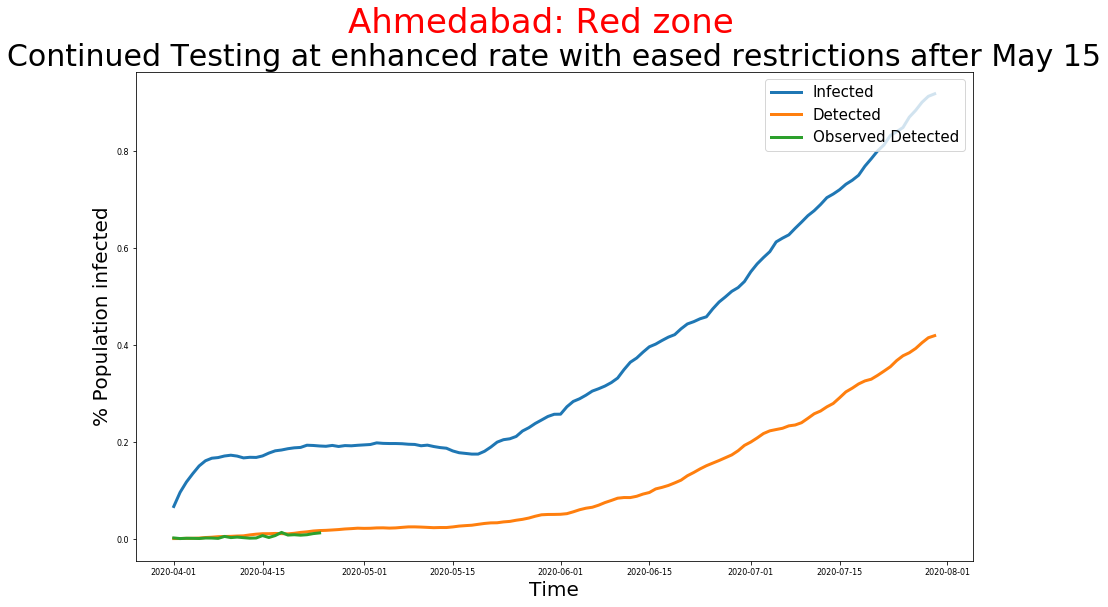

In [8]:
# 4. With enhanced testing and and no social distancing throughout
final = []
initI = 5
theta_E = 0.000
theta_I = 0.01
mf = 1
mf2 = 2
checkpoints  =  {'t': [10,15,45],
                   'theta_E': [0.0002*mf,0.004*mf,0.004*2*mf2],
                 'G': [G_relaxed,G_relaxed,G_normal2]
                      }
for N in Ns:
    print(N)
    temp = monte(initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_Distancing)
    final.append(temp)
fig,ax = plt.subplots()
for i in final:
    df = i['df_I']
    ax.plot(df,linewidth = 3)
    ax.plot(i['df_DI'],linewidth = 3)
    ax.plot(observations.index.values, observations.patient.values,linewidth = 3)
    ax.legend(['Infected','Detected','Observed Detected','I =.11','I =.13'],fontsize =15,loc = 1)
    ax.set_xlabel("Time", fontsize = 20)
    ax.set_ylabel("% Population infected", fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    fig.set_size_inches(15, 9, forward=True)
    plt.suptitle("Ahmedabad: Red zone", fontsize=34,color = "red")
    ax.set_title("Continued Testing at enhanced rate with eased restrictions after May 15",fontsize = 30)
    #ax.text(df.index.values[86],0.05,s = "Total population = 7.5 Million", bbox=dict(facecolor='red', alpha=0.25))
    fig.savefig("4.loose_distancing_enhanced_testing.png")

t = 0.18
	 S   = 9975.0
	 E   = 19.0
	 I   = 6.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 0.0
	 F   = 0.0
[Checkpoint: Updating parameters]
t = 10.17
	 S   = 9964.0
	 E   = 5.0
	 I   = 25.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 6.0
	 F   = 0.0
[Checkpoint: Updating parameters]
t = 20.05
	 S   = 9930.0
	 E   = 9.0
	 I   = 37.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 22.0
	 F   = 0.0
t = 30.03
	 S   = 9908.0
	 E   = 8.0
	 I   = 24.0
	 D_E = 0.0
	 D_I = 1.0
	 R   = 57.0
	 F   = 2.0
t = 40.10
	 S   = 9905.0
	 E   = 3.0
	 I   = 17.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 71.0
	 F   = 2.0
[Checkpoint: Updating parameters]
t = 50.06
	 S   = 9900.0
	 E   = 3.0
	 I   = 15.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 78.0
	 F   = 2.0
t = 60.37
	 S   = 9893.0
	 E   = 3.0
	 I   = 8.0
	 D_E = 0.0
	 D_I = 1.0
	 R   = 91.0
	 F   = 4.0
t = 70.66
	 S   = 9891.0
	 E   = 2.0
	 I   = 7.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 96.0
	 F   = 4.0
t = 90.74
	 S   = 9888.0
	 E   = 1.0
	 I   = 6.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 101.0
	 F   = 4.0
t = 100.62
	

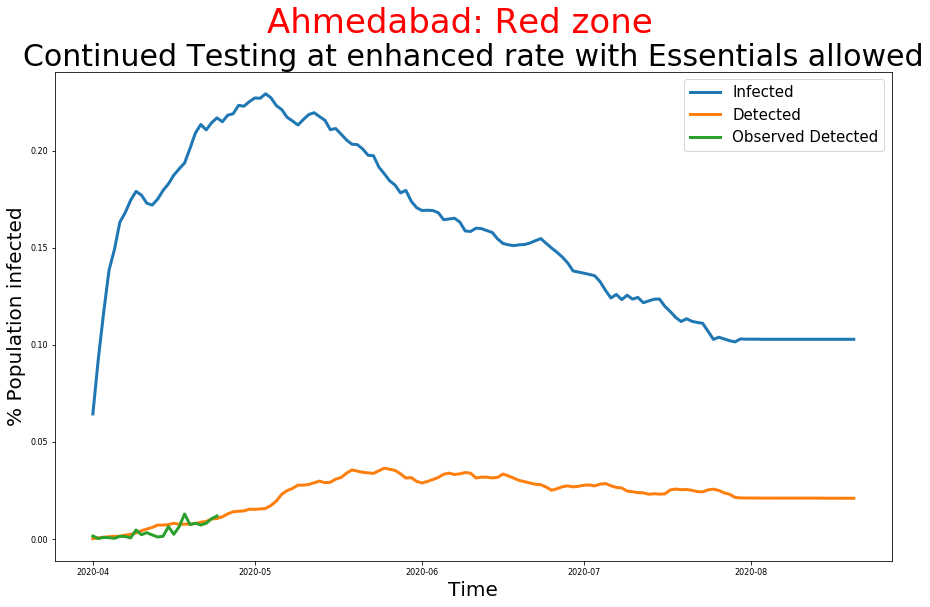

In [9]:
# 5. With enahnced testing and social distancing throughout
final = []
initI = 5
theta_E = 0.000
theta_I = 0.01
mf = 1
mf1 = 3
checkpoints  =  {'t': [10,15,45],
                   'theta_E': [0.0002*mf,0.004*mf,0.004*mf*2],
                 'G': [G_relaxed,G_relaxed,G_relaxed]
                      }

temp = monte(initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_Distancing)
final.append(temp)
fig,ax = plt.subplots()
for i in final:
    df = i['df_I']
    ax.plot(df,linewidth = 3)
    ax.plot(i['df_DI'],linewidth = 3)
    ax.plot(observations.index.values, observations.patient.values,linewidth = 3)
    ax.legend(['Infected','Detected','Observed Detected','I =.11','I =.13'],fontsize =15,loc = 1)
    ax.set_xlabel("Time", fontsize = 20)
    ax.set_ylabel("% Population infected", fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    fig.set_size_inches(15, 9, forward=True)
    plt.suptitle("Ahmedabad: Red zone", fontsize=34,color = "red")
    ax.set_title("Continued Testing at enhanced rate with Essentials allowed",fontsize = 30)
    #ax.text(df.index.values[86],0.05,s = "Total population = 7.5 Million", bbox=dict(facecolor='red', alpha=0.25))
    fig.savefig("5.Social_distancing_enhanced_testing.png")